In [1]:
#Step 1:
#Analyze Microsoft's 10-K filings from 2020 to 2023. For each report, extract key themes from the "Business" and "Risk Factors" sections.

#Step 2:
#Create a dictionary to compile lists of R&D topics identified from the 10-K documents for each respective year.

In [5]:
import openai
from openai import OpenAI
import nltk
from nltk.tokenize import sent_tokenize
from bs4 import BeautifulSoup
import requests
import os

#note from Microsoft 10-K:
# Research and development expenses include payroll, employee benefits, stock-based compensation expense, and other headcount-related expenses associated with product development.
# Research and development expenses also include third-party development and programming costs and the amortization of purchased software code and services content. 

def open_parse_doc(filename):
    """
    Parse an HTML document from a file and return a BeautifulSoup object.
    
    Args:
        filename (str): The name of the HTML file to be parsed.
    
    Returns:
        BeautifulSoup: A BeautifulSoup object representing the parsed HTML.
    """
    with open(filename, 'r') as file:
        html = file.read()
    soup = BeautifulSoup(html, 'html.parser')
    return soup

def get_text(soup):
    """
    Extract text between specified sections in a BeautifulSoup object.
    
    Args:
        soup (BeautifulSoup): The BeautifulSoup object representing the HTML document.
    
    Returns:
        str: Extracted text.
    """
    sec_list = ["Business", "Risk Factors"]
    text = ""
    for i in range(len(sec_list) - 1):
        item_1 = sec_list[i]
        item_2 = sec_list[i + 1]
        a_tag = soup.find('a', text=item_1)
        if a_tag:
            href = a_tag['href']
            href = href[1:]  # removing hashtag in front of id
        a_tag = soup.find('a', text=item_2)
        if a_tag:
            href_2 = a_tag['href']
            href_2 = href_2[1:]  # removing hashtag in front of id
        first_div = soup.find('div', id=href)
        second_div = soup.find('div', id=href_2)
        tag = "div"
        if first_div is None:
            first_div = soup.find('p', id=href)
            second_div = soup.find('p', id=href_2)
            tag = "p"
        if first_div is not None:
            next_div = first_div.find_next_sibling(tag)
            while (next_div != second_div):
                text += next_div.get_text(strip=True)
                next_div = next_div.find_next_sibling(tag)
    return text

def get_topics(text):
    """
    Extract DBPedia topics matching the research and development activities of 'Microsoft'
    from the given text using OpenAI's GPT model.
    
    Args:
        text (str): The text describing research and development activities.
    
    Returns:
        list: List of DBPedia topics.
    """
    research_info = []

    prompt = f"""Extract a set of DBPedia topics that match the research and development activities of 'Boeing',
    as described in the given text:'{text}'. Give only the title of the DBPedia topic. Dont return any sentence but DBPedia topics. Provide output in the same format as:
    '1. BusinessCompany\n2. iPhone\n3. MacBook Air\n4. MacBook Pro\n5.'
    """
    client = OpenAI(
        api_key="API-KEY"
    )

    completion = client.chat.completions.create(
        model="gpt-4-turbo-preview",
        messages=[
            {"role": "user", "content": prompt}
        ]
    )

    # print(completion.choices[0].message)

    # Extract the generated research-related information
    generated_text = completion.choices[0].message.content
    # Append the generated information to the research_info list
    research_info.append(generated_text)
    return research_info

def sort_topics(research_info):
    """
    Sort and process the extracted DBPedia topics from the research information.
    
    Args:
        research_info (list): List of research-related information.
    """
    my_dict = {}
    my_list = []
    for i, info in enumerate(research_info):
        sentences = sent_tokenize(info)
        research_sentences = []
        for sentence in sentences:
            if sentence != "1.":
                modified_string = sentence.split("\n")[0]
                my_list.append(modified_string)

    return my_list
# Dictionary that is going to contain year as a key, list of topics for that year as a value
my_dict = {}
soup = open_parse_doc("../Boeing-10K/Boeing2023.html")
text = get_text(soup)
research_info = get_topics(text)
list_of_topics = sort_topics(research_info)
my_dict[2023] = list_of_topics

soup = open_parse_doc("../Boeing-10K/Boeing2022.html")
text = get_text(soup)
research_info = get_topics(text)
list_of_topics = sort_topics(research_info)
my_dict[2022] = list_of_topics

soup = open_parse_doc("../Boeing-10K/Boeing2021.html")
text = get_text(soup)
research_info = get_topics(text)
list_of_topics = sort_topics(research_info)
my_dict[2021] = list_of_topics

# 2020 doenst work due to href. Different html format for that year?

# soup = open_parse_doc("./Boeing-10K/Boeing2020.html")
# text = get_text(soup)
# research_info = get_topics(text)
# list_of_topics = sort_topics(research_info)
# my_dict[2020] = list_of_topics

for key,val in my_dict.items():
    print("Year: ", key)
    print("Topics: ", val)

/tmp/ipykernel_2291399/1403280196.py:43: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  a_tag = soup.find('a', text=item_1)
/tmp/ipykernel_2291399/1403280196.py:47: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  a_tag = soup.find('a', text=item_2)


Year:  2023
Topics:  ['Boeing', 'Aerospace', 'Commercial Airplanes', 'Defense, Space & Security', 'Global Services', 'Boeing 737', 'Boeing 767', 'Boeing 777', 'Boeing 787 Dreamliner', 'Boeing 777X', 'Unmanned Aerial Vehicles', 'Satellite', 'Space Exploration', 'Environmental Regulation', 'Intellectual Property']
Year:  2022
Topics:  ['Boeing', 'Boeing Commercial Airplanes', 'Boeing Defense, Space & Security', 'Boeing Global Services', 'Boeing Capital', 'Commercial jet aircraft', 'Military aircraft', 'Unmanned aerial vehicles', 'Satellite', 'Space exploration', 'Cybersecurity', 'Environmental regulation', 'Aerospace materials', 'Intellectual property', 'Labor union']
Year:  2021
Topics:  ['Boeing', 'Boeing_Commercial_Airplanes', 'Boeing_Defense,_Space_&_Security', 'Boeing_Global_Services', 'Boeing_Capital', 'Boeing_737', 'Boeing_747', 'Boeing_767', 'Boeing_777', 'Boeing_787_Dreamliner', 'Boeing_777X', 'Boeing_737_MAX', 'F/A-18E/F_Super_Hornet', 'Boeing_F-15_Strike_Eagle', 'Boeing_P-8_Po

In [6]:
#Step 3:
#Visualize the distribution of topics over the years using a graphical representation.

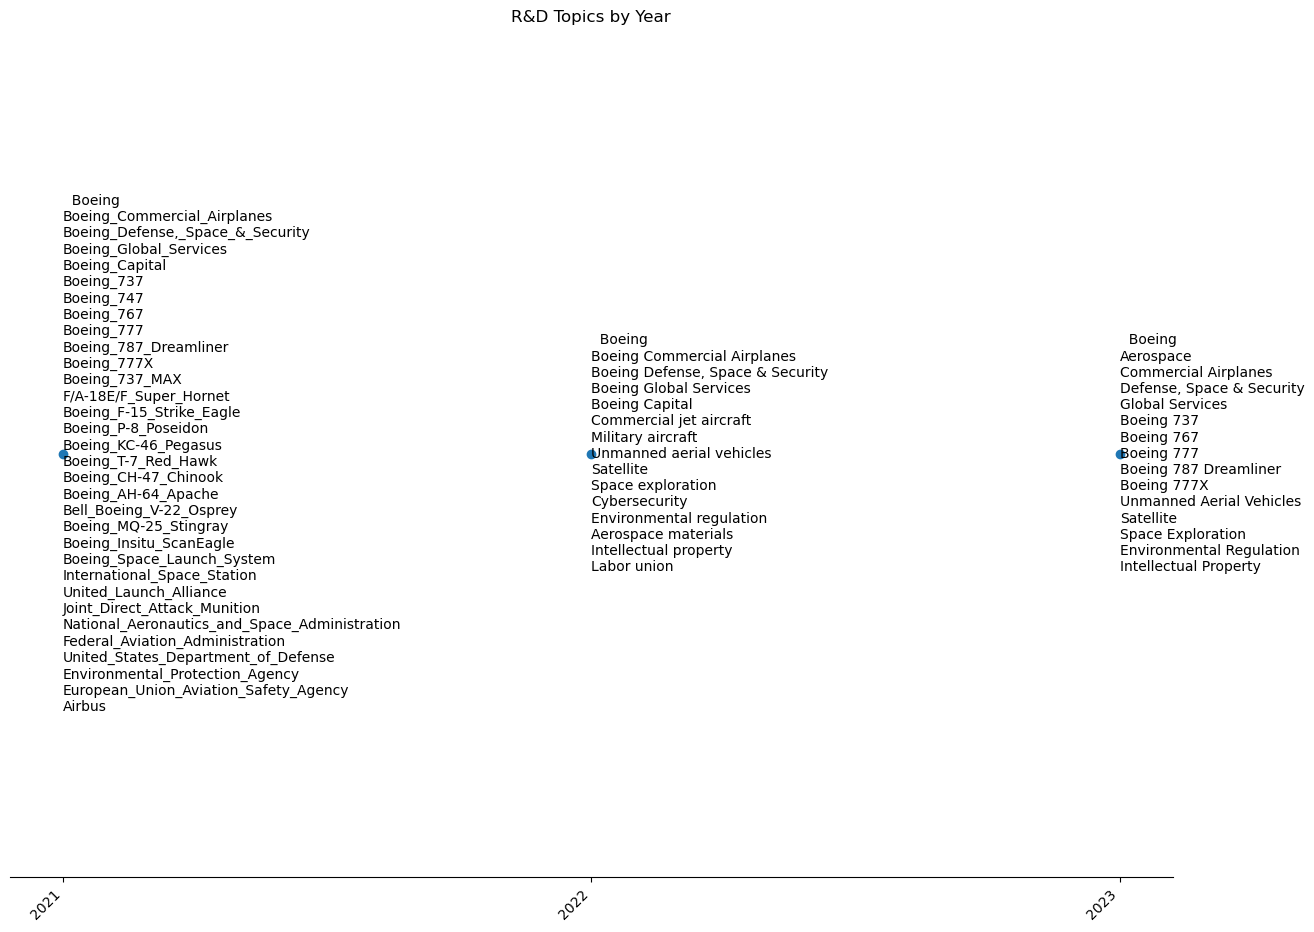

In [7]:
import matplotlib.pyplot as plt
def plot_topics(my_dict):
    """
    Plots R&D topics over the years as a scatter plot with annotations.

    This function takes a dictionary where each key is a year and each value is a list of topics
    related to R&D for that year. It generates a scatter plot with each year marked on the x-axis.
    Topics for each year are displayed as annotations next to the corresponding year mark on the plot.
    The y-axis is not used to encode data and is hidden.

    Parameters:
    - my_dict (dict): A dictionary with years as keys (int or str) and a list of strings (topics) as values.

    Returns:
    - None: The function directly displays the plot and does not return any value.

    Requires:
    - matplotlib.pyplot: This function relies on matplotlib for generating and displaying the plot.
    """
    fig, ax = plt.subplots(figsize=(15, 11))
    years = list(my_dict.keys())
    topics = ["\n".join(my_dict[year]) for year in years]


    ax.scatter(years, [1] * len(years))
    for i, topic in enumerate(topics):
        ax.text(years[i], 1, '  ' + topic, va='center')


    ax.get_yaxis().set_visible(False)  
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(years)
    ax.set_xticklabels(years, rotation=45, ha='right')
    ax.set_title('R&D Topics by Year')

    plt.show()
plot_topics(my_dict)

In [8]:
#Step 4:
#Instruct ChatGPT to enumerate the R&D topics for a specified year, as identified in the 10-K analyses.

In [9]:

def categorize_topics(year):
    """
    Extract DBPedia topics matching the research and development activities of 'Boeing'
    from the given text using OpenAI's GPT model.
    
    Args:
        text (str): The text describing research and development activities.
    
    Returns:
        list: List of DBPedia topics.
    """
    research_info = []

    prompt = f"""List all primary investment themes by Boeing in {year}, focusing on distinct categories without detailed descriptions.Provide output in the same format as:
    '1. Topic#1\n2. Topic#2\n3. Topic#3\n4.Topic#3\n5."""
    client = OpenAI(
        api_key="API-KEY"
    )

    completion = client.chat.completions.create(
        model="gpt-4-turbo-preview",
        messages=[
            {"role": "user", "content": prompt}
        ]
    )

    # print(completion.choices[0].message)

    # Extract the generated research-related information
    generated_text = completion.choices[0].message.content
    # Append the generated information to the research_info list
    research_info.append(generated_text)
    return research_info

In [10]:
# Step 5:
# Establish a second dictionary to catalog lists of R&D topics for each year, this time derived from ChatGPT's research insights.


In [11]:
chat_gpt_dict = {}

research_info = categorize_topics("2020")
list_of_topics = sort_topics(research_info)
chat_gpt_dict[2020] = list_of_topics

research_info = categorize_topics("2021")
list_of_topics = sort_topics(research_info)
chat_gpt_dict[2021] = list_of_topics

research_info = categorize_topics("2022")
list_of_topics = sort_topics(research_info)
chat_gpt_dict[2022] = list_of_topics

research_info = categorize_topics("2023")
list_of_topics = sort_topics(research_info)
chat_gpt_dict[2023] = list_of_topics

In [12]:
print(chat_gpt_dict)

{2020: ['Commercial Airplane Manufacturing', 'Defense, Space, and Security', 'Global Services', 'Innovation in Aerospace Technologies', 'Environmental Sustainability Initiatives'], 2021: ['Sustainability and Environmental Technologies', 'Autonomous Systems', 'Advanced Manufacturing and Materials', 'Artificial Intelligence and Machine Learning', 'Cybersecurity', 'Space Exploration and Satellite Technology'], 2022: ['Sustainable Aerospace and ESG Initiatives', 'Advanced Air Mobility and Urban Air Mobility Solutions', 'Defense, Space, and Security advancements', 'Digital Transformation and Artificial Intelligence Applications', 'Supply Chain Resilience and Optimization'], 2023: ['Sustainable Aviation Fuels (SAF) and Environmental Initiatives', 'Autonomous and Unmanned Systems', 'Space Exploration and Satellite Technologies', 'Advanced Manufacturing and Materials Innovations', 'Digital Aviation and Artificial Intelligence Applications', 'Global Defense and Security Solutions']}


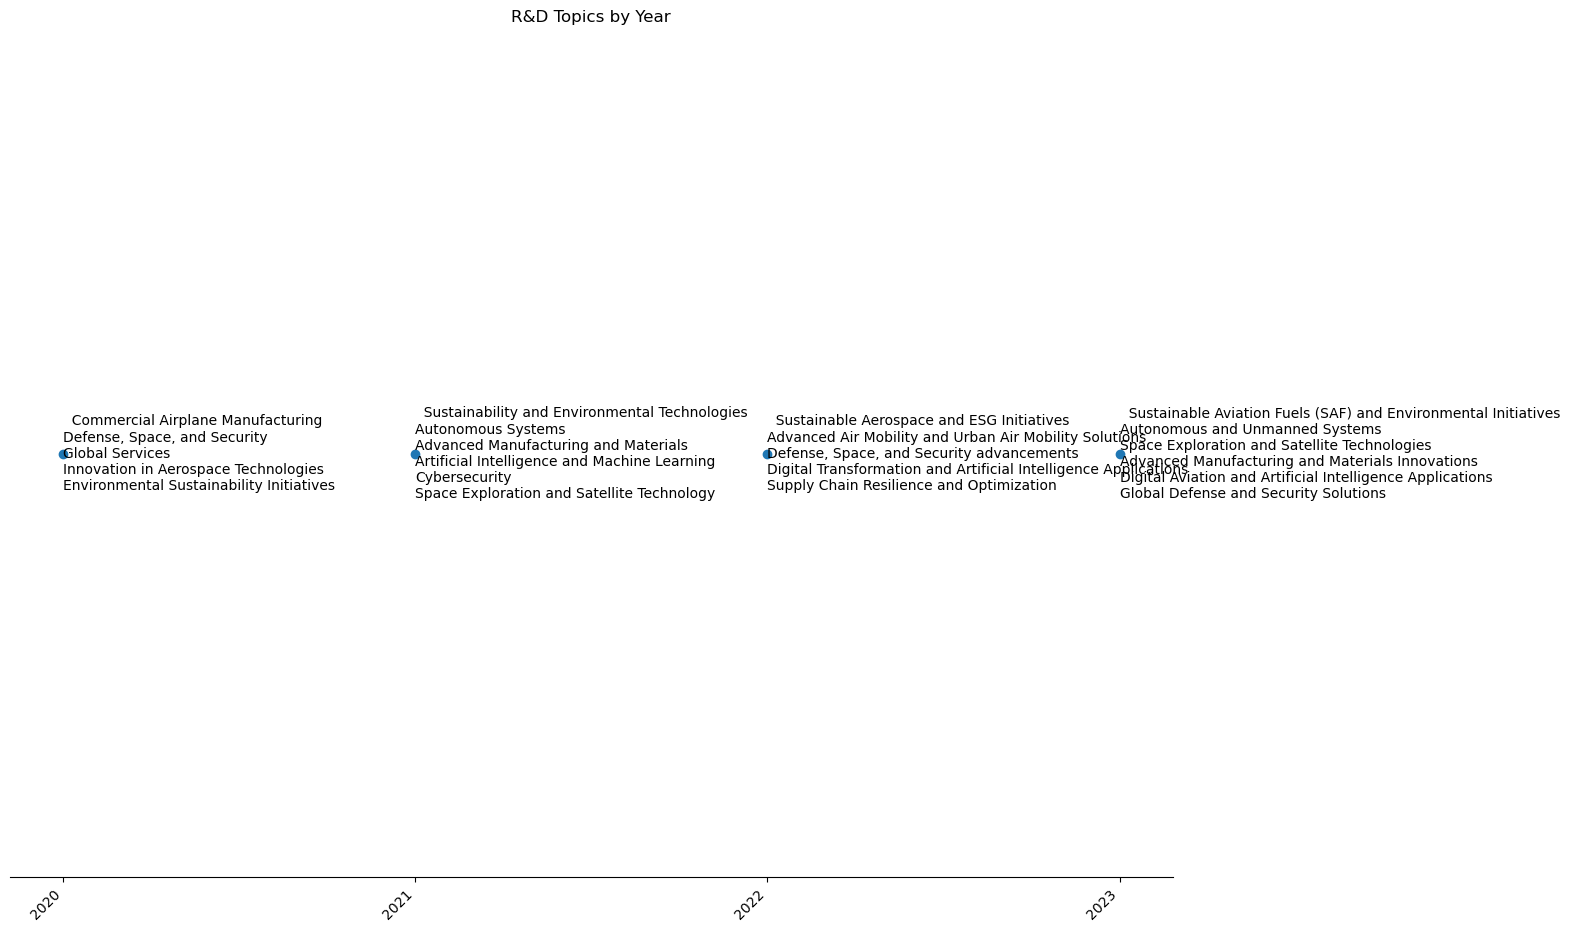

In [13]:
#Step 6:
#Graphically represent the R&D topics to illustrate trends and patterns.
plot_topics(chat_gpt_dict)

In [17]:
def categorize_patent(title, text):
    research_info = []
    # Identifying specific categories for main investment areas. 
    topics = chat_gpt_dict[2023]
    prompt = f"""Given title: {title} and description {text} of the patent, categorize it into one of the major categories from this list: {topics}. Please output only the category"""
    client = OpenAI(
        api_key="API-KEY"
    )

    completion = client.chat.completions.create(
        model="gpt-4-turbo-preview",
        messages=[
            {"role": "user", "content": prompt}
        ]
    )

    # print(completion.choices[0].message)

    # Extract the generated research-related information
    generated_text = completion.choices[0].message.content
    # Append the generated information to the research_info list
    research_info.append(generated_text)
    return research_info

In [18]:
#Step 7:
#Retrieve Microsoft's patent filings for a chosen year and gather relevant data.
#Step 8:
#Classify each patent into one of the predefined R&D topic categories, based on the patent's abstract, to understand the alignment with identified themes.


In [19]:
import urllib3
#import requests  # Import the requests library
#https://developer.uspto.gov/ibd-api/swagger-ui/index.html#/bulkdata/searchPublicationData

# Disable SSL verification warnings
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Define the USPTO API endpoint and parameters for searching publication data
# on the website, for nvidia last patents was made in 2013?
url = 'https://developer.uspto.gov/ibd-api/v1/application/publications'
params = {
    'publicationFromDate': '2022-12-01',
    # 'publicationToDate': '2022-12-31',
    # 'filingDateFromDate': '2013-09-01',
    # 'filingDateToDate': '2022-12-31',
    'assigneeEntityName': 'Boeing'  # Adjusted for specificity
}
headers = {'accept': 'application/json'}

# Make the GET request to the USPTO API
response = requests.get(url, params=params, headers=headers, verify=False)

# Initialize variables for processing the response
count = 0
my_dict = {}

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    # Check if 'results' key exists in the response data
    if 'results' in data:
        for item in data['results']:
            patent_number = item.get('patentApplicationNumber', 'N/A')
            title = item.get('inventionTitle', 'N/A')
            abstractText = item.get('abstractText', 'N/A')
            
            # Print the retrieved patent data
            print('Patent Number:', patent_number)
            print('Title:', title)
            print('Abstract:', abstractText)
            print("Category: ")
            print(categorize_patent(title, abstractText))
            print('-----')
            
            # Increment the counter for each patent found
            count += 1
    else:
        print('No results found in the response data.')
else:
    print('Request failed with status code:', response.status_code)

# Print the total count of patents retrieved
print('Total patents found:', count)


Patent Number: US17677036
Title: IN SITU CRACK REPAIR IN STRUCTURES
Abstract: ['A method for repairing a crack in a structure includes mounting a manifold to the structure around the crack. The structure has a nonplanar surface contour that surrounds the crack. The manifold has a base portion, a cover portion, and a plug. The base portion has a grip surface configured to conform to the nonplanar surface contour of the structure. The cover portion is connected to the base portion, and has an injection port and a vent port in fluid communication with a channel aligned to the crack. The injection port transfers a bonding material into and out of the channel. The plug closes and opens the vent port. The method includes filling the channel with the bonding material to direct the bonding material into the crack, and draining the bonding material from the manifold.']
Category: 
['Advanced Manufacturing and Materials Innovations']
-----
Patent Number: US17721401
Title: Protection System for Ai